In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


In [2]:
# Dataset path
data_dir = "dataset"  # Set your dataset root path

# Image size
img_size = 224

# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop(img_size, scale=(0.9,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Load datasets
train_ds = datasets.ImageFolder(os.path.join(data_dir,"train"), transform=train_transforms)
val_ds   = datasets.ImageFolder(os.path.join(data_dir,"validation"), transform=val_transforms)
test_ds  = datasets.ImageFolder(os.path.join(data_dir,"test"), transform=val_transforms)

# DataLoaders
train_ld = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_ld   = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4)
test_ld  = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=4)

# Check
print("Classes:", train_ds.classes)
print("Train:", len(train_ds), "Validation:", len(val_ds), "Test:", len(test_ds))

Classes: ['diabetes', 'nondiabetes']
Train: 2500 Validation: 600 Test: 50


In [3]:
# Load pretrained EfficientNet-B0
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Replace classifier for 2 classes
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
model = model.to(device)
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)

In [5]:
def run_epoch(loader, train=True):
    model.train(train)
    losses, preds_all, labels_all = [], [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        with torch.set_grad_enabled(train):
            out = model(x)
            loss = criterion(out, y)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        losses.append(loss.item())
        preds_all.append(out.detach().softmax(1)[:,1].cpu().numpy())
        labels_all.append(y.cpu().numpy())
    preds_all = np.concatenate(preds_all)
    labels_all = np.concatenate(labels_all)
    auc = roc_auc_score(labels_all, preds_all)
    acc = accuracy_score(labels_all, (preds_all>=0.5).astype(int))
    return np.mean(losses), acc, auc, labels_all, preds_all

In [6]:
best_auc = 0.0
num_epochs = 25
best_model_path = "best_efficientnet_b0.pth"

train_losses, val_losses = [], []
train_aucs, val_aucs = [], []

for epoch in range(num_epochs):
    tr_loss, tr_acc, tr_auc, _, _ = run_epoch(train_ld, train=True)
    va_loss, va_acc, va_auc, _, _ = run_epoch(val_ld, train=False)
    
    scheduler.step()
    
    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    train_aucs.append(tr_auc)
    val_aucs.append(va_auc)
    
    print(f"Epoch {epoch+1:02d} | Train Loss: {tr_loss:.4f} Acc: {tr_acc:.3f} AUC: {tr_auc:.3f} | "
          f"Val Loss: {va_loss:.4f} Acc: {va_acc:.3f} AUC: {va_auc:.3f}")
    
    if va_auc > best_auc:
        best_auc = va_auc
        torch.save(model.state_dict(), best_model_path)

print("Best model saved at:", best_model_path)

# Save training data to CSV for custom graph creation
import pandas as pd

# Create DataFrame with training history
training_data = {
    'epoch': list(range(1, num_epochs + 1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_auc': train_aucs,
    'val_auc': val_aucs
}

df = pd.DataFrame(training_data)

# Save to CSV
csv_filename = 'efficientnet_b0_training_history.csv'
df.to_csv(csv_filename, index=False)
print(f"Training data saved to: {csv_filename}")

# Display first few rows
print("\nTraining History Data:")
print(df.head())
print(f"\nTotal epochs: {len(df)}")
print(f"Best validation AUC: {max(val_aucs):.4f} at epoch {val_aucs.index(max(val_aucs)) + 1}")

Epoch 01 | Train Loss: 0.2204 Acc: 0.913 AUC: 0.972 | Val Loss: 0.0932 Acc: 0.967 AUC: 0.997
Epoch 02 | Train Loss: 0.0603 Acc: 0.979 AUC: 0.997 | Val Loss: 0.0350 Acc: 0.990 AUC: 1.000
Epoch 02 | Train Loss: 0.0603 Acc: 0.979 AUC: 0.997 | Val Loss: 0.0350 Acc: 0.990 AUC: 1.000
Epoch 03 | Train Loss: 0.0338 Acc: 0.989 AUC: 0.999 | Val Loss: 0.0243 Acc: 0.993 AUC: 1.000
Epoch 03 | Train Loss: 0.0338 Acc: 0.989 AUC: 0.999 | Val Loss: 0.0243 Acc: 0.993 AUC: 1.000
Epoch 04 | Train Loss: 0.0300 Acc: 0.990 AUC: 0.999 | Val Loss: 0.0391 Acc: 0.980 AUC: 1.000
Epoch 04 | Train Loss: 0.0300 Acc: 0.990 AUC: 0.999 | Val Loss: 0.0391 Acc: 0.980 AUC: 1.000
Epoch 05 | Train Loss: 0.0141 Acc: 0.998 AUC: 1.000 | Val Loss: 0.0301 Acc: 0.987 AUC: 1.000
Epoch 05 | Train Loss: 0.0141 Acc: 0.998 AUC: 1.000 | Val Loss: 0.0301 Acc: 0.987 AUC: 1.000
Epoch 06 | Train Loss: 0.0228 Acc: 0.992 AUC: 1.000 | Val Loss: 0.0326 Acc: 0.993 AUC: 1.000
Epoch 06 | Train Loss: 0.0228 Acc: 0.992 AUC: 1.000 | Val Loss: 0.0326

In [7]:
# Load best model
model.load_state_dict(torch.load(best_model_path, map_location=device, weights_only=True))
model.eval()

# TEST DATASET EVALUATION
import torch
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Define transforms (same as your original test transforms)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load Test dataset
test_ds = datasets.ImageFolder("SelfCollectedTest", transform=val_transforms)
test_ld = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# Load best model
model.load_state_dict(torch.load('best_efficientnet_b0.pth', map_location=device, weights_only=True))
model.eval()

probs, labels = [], []

with torch.no_grad():
    for x, y in test_ld:
        x = x.to(device)
        out = model(x).softmax(1)[:, 1].cpu().numpy()
        probs.append(out)
        labels.append(y.numpy())

probs = np.concatenate(probs)
labels = np.concatenate(labels)
preds = (probs >= 0.5).astype(int)

# Metrics
acc = accuracy_score(labels, preds)
auc = roc_auc_score(labels, probs)
report = classification_report(labels, preds, target_names=test_ds.classes, digits=3)
cm = confusion_matrix(labels, preds)
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0

print("Test Accuracy:", acc)
print("Test AUC:", auc)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print(report)

Test Accuracy: 0.9653465346534653
Test AUC: 0.9968691794922067
Sensitivity: 0.9851485148514851
Specificity: 0.9455445544554455
              precision    recall  f1-score   support

    diabetes      0.985     0.946     0.965       404
 nondiabetes      0.948     0.985     0.966       404

    accuracy                          0.965       808
   macro avg      0.966     0.965     0.965       808
weighted avg      0.966     0.965     0.965       808



In [8]:

sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0

print("Test Accuracy:", acc)
print("Test AUC:", auc)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print(report)

Test Accuracy: 0.9653465346534653
Test AUC: 0.9968691794922067
Sensitivity: 0.9851485148514851
Specificity: 0.9455445544554455
              precision    recall  f1-score   support

    diabetes      0.985     0.946     0.965       404
 nondiabetes      0.948     0.985     0.966       404

    accuracy                          0.965       808
   macro avg      0.966     0.965     0.965       808
weighted avg      0.966     0.965     0.965       808



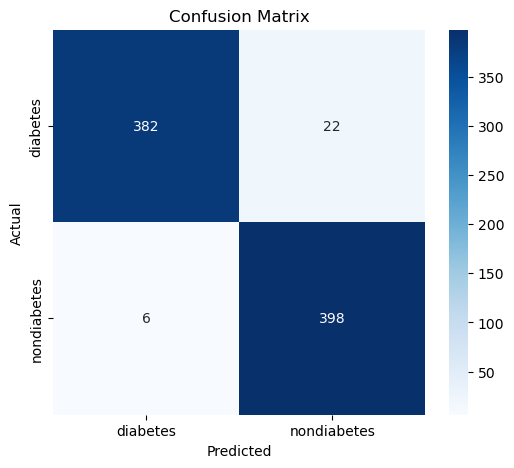

In [9]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_ds.classes, yticklabels=test_ds.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [10]:
dummy = torch.randn(1,3,img_size,img_size, device=device)

# TorchScript
traced_model = torch.jit.trace(model, dummy)
traced_model.save("diabetes_efficientnet_b0_ts.pt")
print("TorchScript model saved!")

# ONNX
torch.onnx.export(model, dummy, "diabetes_efficientnet_b0.onnx",
                  input_names=["input"], output_names=["output"],
                  opset_version=13, do_constant_folding=True,
                  dynamic_axes={"input":{0:"batch"}, "output":{0:"batch"}})
print("ONNX model saved!")

TorchScript model saved!
ONNX model saved!
ONNX model saved!


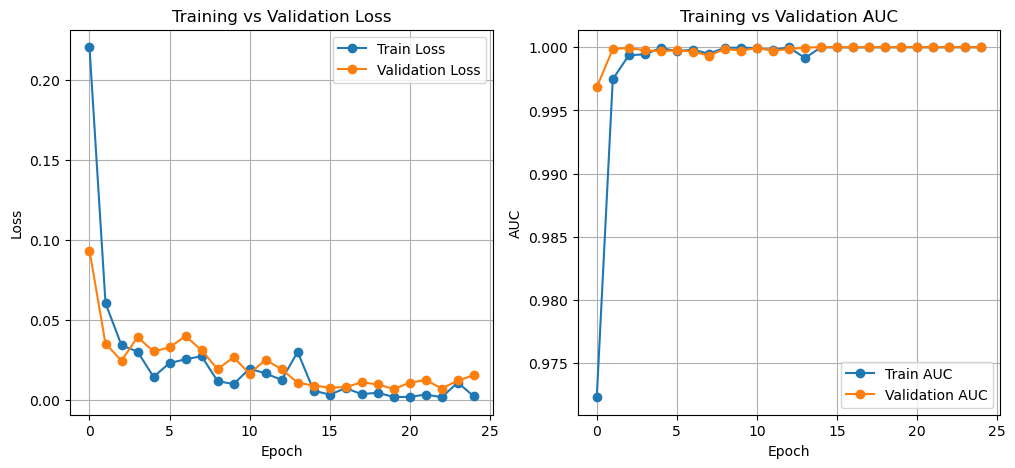

In [11]:
# Plot Training vs Validation Loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

# Plot Training vs Validation AUC (Accuracy optional)
plt.subplot(1,2,2)
plt.plot(train_aucs, label='Train AUC', marker='o')
plt.plot(val_aucs, label='Validation AUC', marker='o')
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("Training vs Validation AUC")
plt.legend()
plt.grid(True)

plt.show()

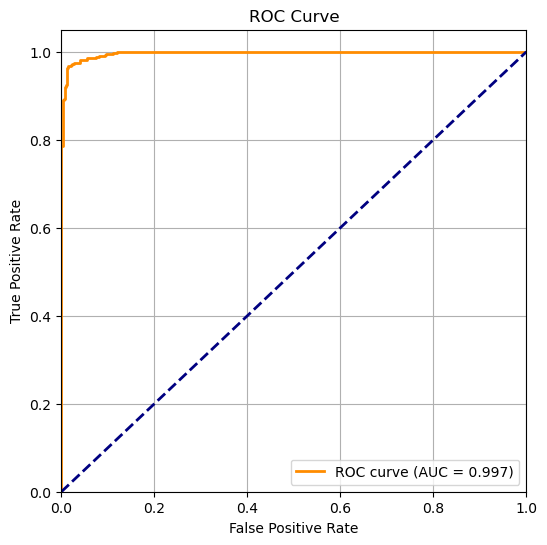

In [12]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

device: cuda
Found 50 test samples across classes: ['diabetes', 'nondiabetes']
class_to_idx: {'diabetes': 0, 'nondiabetes': 1}


C:\Users\tawhi\AppData\Local\Temp\ipykernel_20496\3800824854.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=de

Indices: [36, 3, 20, 29, 30, 7]
------------------------------------------------------------
Sample 1: idx=36 file=r_nd_(214).jpg
GT: nondiabetes (index 1)
Logits: [-6.953082   7.0685506]
Probs: {'diabetes': 8.137325835377851e-07, 'nondiabetes': 0.9999991655349731}
Pred: nondiabetes (index 1)
------------------------------------------------------------
Sample 2: idx=3 file=r_d_(176).jpg
GT: diabetes (index 0)
Logits: [ 3.529772 -3.457771]
Probs: {'diabetes': 0.999077558517456, 'nondiabetes': 0.0009224605746567249}
Pred: diabetes (index 0)
------------------------------------------------------------
Sample 1: idx=36 file=r_nd_(214).jpg
GT: nondiabetes (index 1)
Logits: [-6.953082   7.0685506]
Probs: {'diabetes': 8.137325835377851e-07, 'nondiabetes': 0.9999991655349731}
Pred: nondiabetes (index 1)
------------------------------------------------------------
Sample 2: idx=3 file=r_d_(176).jpg
GT: diabetes (index 0)
Logits: [ 3.529772 -3.457771]
Probs: {'diabetes': 0.999077558517456, 'nond

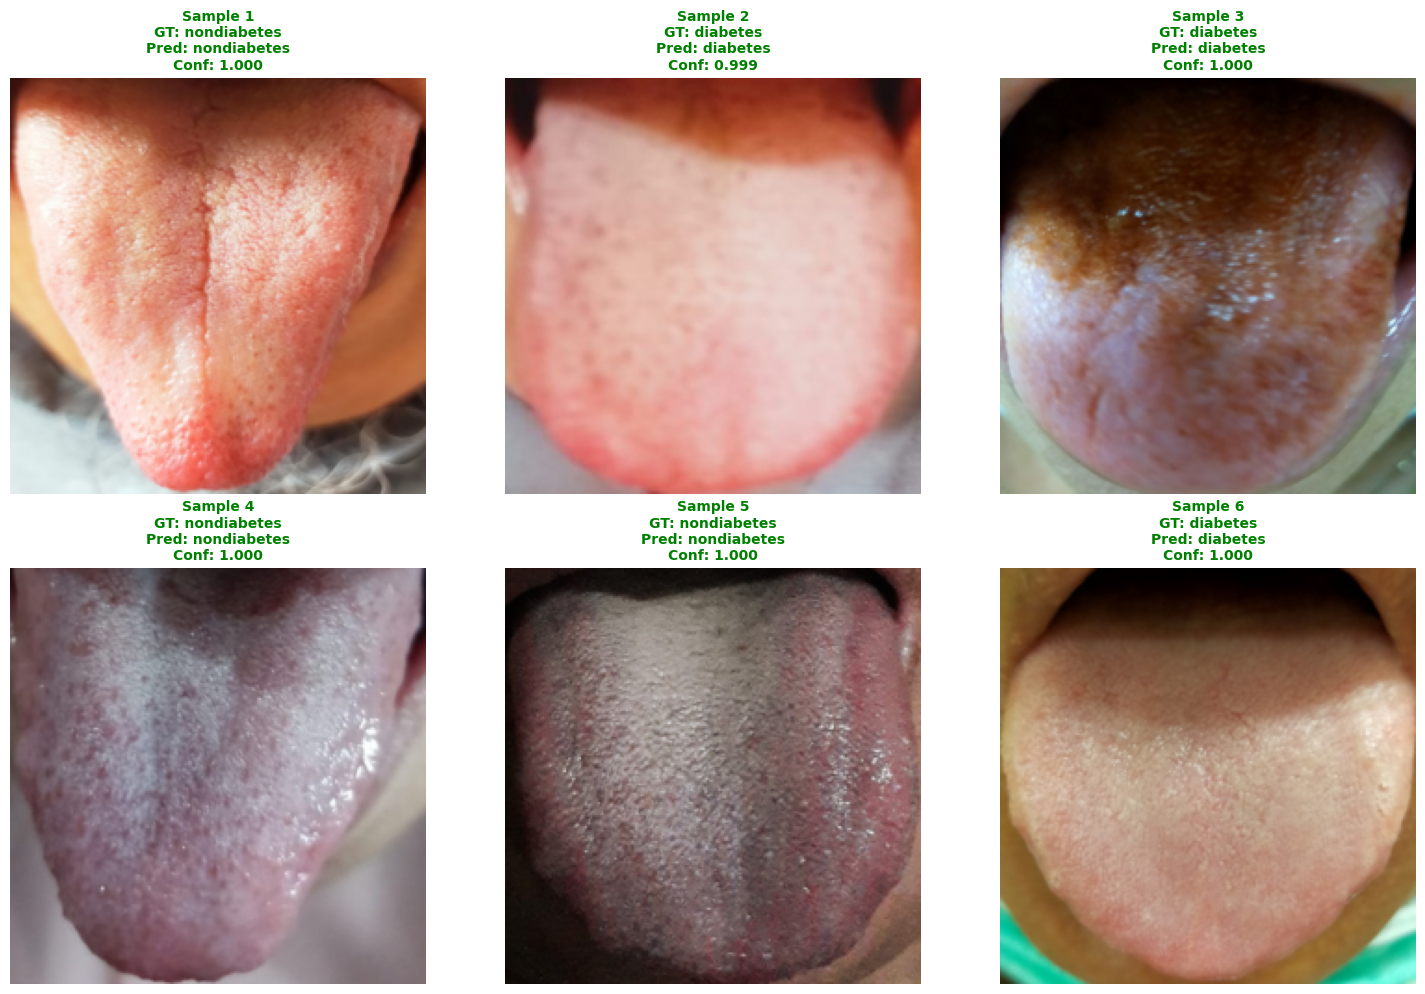


Done.


In [13]:
import os, random
import numpy as np
import torch
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt

# Config
data_dir = 'dataset'
test_dir = os.path.join(data_dir, 'test')

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device:', device)

# Transforms (match notebook val_transforms)
img_size = 224
val_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Dataset
test_ds = datasets.ImageFolder(test_dir, transform=val_transforms)
print('Found', len(test_ds), 'test samples across classes:', test_ds.classes)
print('class_to_idx:', test_ds.class_to_idx)

# Model architecture (no pretrained weights here; we will load your checkpoint)
model = models.efficientnet_b0(weights=None)
# adapt classifier
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 2)
# load weights
ckpt_path = 'best_efficientnet_b0.pth'
if not os.path.exists(ckpt_path):
    raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model = model.to(device)
model.eval()

# Sampling
num_samples = 6
indices = random.sample(range(len(test_ds)), num_samples)
print('Indices:', indices)

# Helper function to denormalize image for display
def denormalize_image(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    denorm = tensor * std + mean
    return torch.clamp(denorm, 0, 1)

# Create subplot grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, idx in enumerate(indices):
    img, label = test_ds[idx]
    img_path = test_ds.imgs[idx][0]
    
    # Predict
    img_batch = img.unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(img_batch)  # logits
        logits = out[0].cpu().numpy()
        probs = torch.softmax(out, dim=1)[0].cpu().numpy()
        pred_idx = int(np.argmax(logits))
        pred_class = test_ds.classes[pred_idx]

    # Display image
    img_denorm = denormalize_image(img)
    axes[i].imshow(img_denorm.permute(1, 2, 0))
    axes[i].axis('off')
    
    # Create title with prediction info
    gt_class = test_ds.classes[label]
    confidence = float(probs[pred_idx])
    title_color = 'green' if pred_class == gt_class else 'red'
    
    title = f'Sample {i+1}\nGT: {gt_class}\nPred: {pred_class}\nConf: {confidence:.3f}'
    axes[i].set_title(title, fontsize=10, color=title_color, weight='bold')
    
    # Print detailed info
    print('-'*60)
    print(f'Sample {i+1}: idx={idx} file={os.path.basename(img_path)}')
    print('GT:', gt_class, f'(index {label})')
    print('Logits:', logits)
    print('Probs:', {test_ds.classes[0]: float(probs[0]), test_ds.classes[1]: float(probs[1])})
    print('Pred:', pred_class, f'(index {pred_idx})')

plt.tight_layout()
plt.show()

print('\nDone.')